# Analyzing @netanyahu Tweets using Time series & NLP techniques

By Ori Rosenthal

In [1]:
import pandas as pd
import numpy as np
import twint
import requests
import string
import emoji
import re
import datetime as dt
from wordcloud import WordCloud, STOPWORDS
from bidi.algorithm import get_display
from pygooglenews import GoogleNews
from googletrans import Translator
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer 
from sklearn.cluster import KMeans
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer, WordNetLemmatizer
from nltk.probability import FreqDist
from textblob import TextBlob
from gensim.corpora import Dictionary
from gensim import matutils, models
from gensim.models import CoherenceModel
import scipy.sparse
import spacy
from spacy import displacy
from collections import Counter
import en_core_web_sm
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as mtick
import seaborn as sns
from IPython.core.display import display, HTML
import warnings
warnings.filterwarnings("ignore")

# plt.style.use('fivethirtyeight')
%matplotlib inline

In [2]:
# !twint -u netanyahu --since 2008-01-01 -o all_netanyahu_tweets.csv --csv
df = pd.read_csv('all_netanyahu_tweets.csv', sep='\t')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7206 entries, 0 to 7205
Data columns (total 36 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               7206 non-null   int64  
 1   conversation_id  7206 non-null   int64  
 2   created_at       7206 non-null   object 
 3   date             7206 non-null   object 
 4   time             7206 non-null   object 
 5   timezone         7206 non-null   int64  
 6   user_id          7206 non-null   int64  
 7   username         7206 non-null   object 
 8   name             7206 non-null   object 
 9   place            0 non-null      float64
 10  tweet            7206 non-null   object 
 11  language         7206 non-null   object 
 12  mentions         7206 non-null   object 
 13  urls             7206 non-null   object 
 14  photos           7206 non-null   object 
 15  replies_count    7206 non-null   int64  
 16  retweets_count   7206 non-null   int64  
 17  likes_count   

In [4]:
# dropping columns according to NAN percentage threshold (keep all those columns with 70% Non-na values).
df.dropna(axis=1, thresh = int(0.7*df.shape[0]), inplace=True)
# converting columns (date,time) into datetime format, setting date as index and droppiong irrelevant features. 
df['date'] = pd.to_datetime(df['date'])
df['time'] = pd.to_datetime(df['time'])
df.set_index(df['date'], inplace=True)
df = df.sort_index()
df.drop(['id','conversation_id','username','name','created_at','timezone','cashtags'],axis=1, inplace=True)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 7206 entries, 2008-10-30 to 2021-03-24
Data columns (total 16 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   date            7206 non-null   datetime64[ns]
 1   time            7206 non-null   datetime64[ns]
 2   user_id         7206 non-null   int64         
 3   tweet           7206 non-null   object        
 4   language        7206 non-null   object        
 5   mentions        7206 non-null   object        
 6   urls            7206 non-null   object        
 7   photos          7206 non-null   object        
 8   replies_count   7206 non-null   int64         
 9   retweets_count  7206 non-null   int64         
 10  likes_count     7206 non-null   int64         
 11  hashtags        7206 non-null   object        
 12  link            7206 non-null   object        
 13  retweet         7206 non-null   bool          
 14  video           7206 non-null   int64 

In [6]:
df.head()

,date,time,user_id,tweet,language,mentions,urls,photos,replies_count,retweets_count,likes_count,hashtags,link,retweet,video,reply_to
date,,,,,,,,,,,,,,,,
2008-10-30,2008-10-30,2021-03-31 08:45:22,17061263,היום בערב כנסים ברמלה ובגבעתים,iw,[],[],[],12,8,32,[],https://twitter.com/netanyahu/status/981805657,False,0,[]
2008-11-02,2008-11-02,2021-03-31 13:47:49,17061263,נכנס עכשיו למסיבת עיתונאים עם מירי רגב- מצטרפת...,iw,[],[],[],34,8,131,[],https://twitter.com/netanyahu/status/986233276,False,0,[]
2008-11-03,2008-11-03,2021-03-31 14:22:06,17061263,בישיבת סיעה בכנסת,iw,[],[],[],0,0,1,[],https://twitter.com/netanyahu/status/987513960,False,0,[]
2008-11-05,2008-11-05,2021-03-31 10:13:49,17061263,העלינו עמוד תומכים בפייסבוק: http://tinyurl.c...,iw,[],[],[],0,0,1,[],https://twitter.com/netanyahu/status/991348948,False,0,[]
2008-11-06,2008-11-06,2021-03-31 14:04:17,17061263,עובדים במרץ על אתר חדש.,iw,[],[],[],0,0,1,[],https://twitter.com/netanyahu/status/993157576,False,0,[]


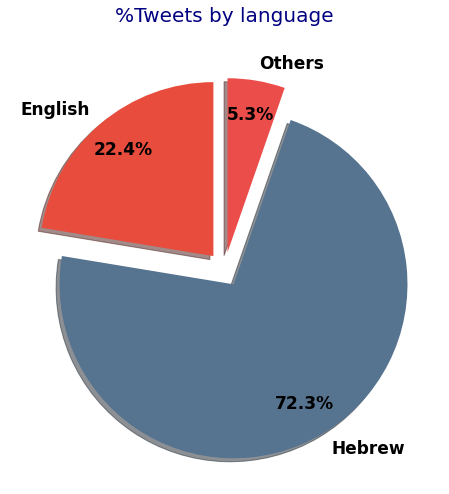

In [7]:
# number of tweets by language
l_pie = (
     df['language'].value_counts(normalize=True)
    .to_frame()
    .reset_index()
    .rename(columns={'index':'l_code','language':'percentage'})
    .replace({'l_code':{'iw':'Hebrew','en':'English'}})
    .assign(language = lambda x: np.select([x['percentage'] > 0.05,x['percentage']<=0.05],[x['l_code'], "Others"]))
    .groupby('language')['percentage'].sum())
          
fig1, ax = plt.subplots(figsize=(8,8))
ax.pie(l_pie, explode=(0.1,0.1,0.1),autopct='%1.1f%%', labels=l_pie.index,colors = [ '#e74c3c', '#56738f','#eb4d4b'],
       shadow=True, startangle=90,pctdistance=0.8, labeldistance=1.1, textprops={'fontsize': 17, 'weight':'bold'});
ax.set_title("%Tweets by language", size=20,color='navy',pad=30);

In [8]:
total_ndays = (df.date.max() - df.date.min()).days
print(f"Total number of days: {total_ndays}")
print(f"The average number of tweets sent per day: {round(len(df)/total_ndays,1)}")
print(f"Number of Hebrew tweets per day on average: {round(len(df[df.language == 'iw'])/total_ndays,1)}")
print(f"Number of English tweets per day on average: {round(len(df[df.language == 'en'])/total_ndays,1)}")

Total number of days: 4528
The average number of tweets sent per day: 1.6
Number of Hebrew tweets per day on average: 1.2
Number of English tweets per day on average: 0.4


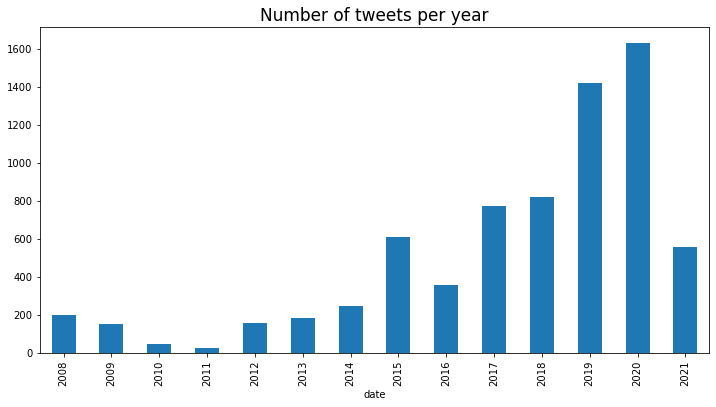

In [9]:
fig, ax = plt.subplots(figsize=(12,6))
yearly_tweets = df.resample('Y')['tweet'].count()
yearly_tweets.index = yearly_tweets.index.year
yearly_tweets.plot(kind='bar');
plt.title('Number of tweets per year', size=17);

#### Number of characters in a tweet
* The distribution's midian value is represented by vertical dashed lines.

count    7206.0
mean      136.0
std        71.0
min         1.0
25%        83.0
50%       133.0
75%       173.0
max       312.0
Name: tweet_len, dtype: float64


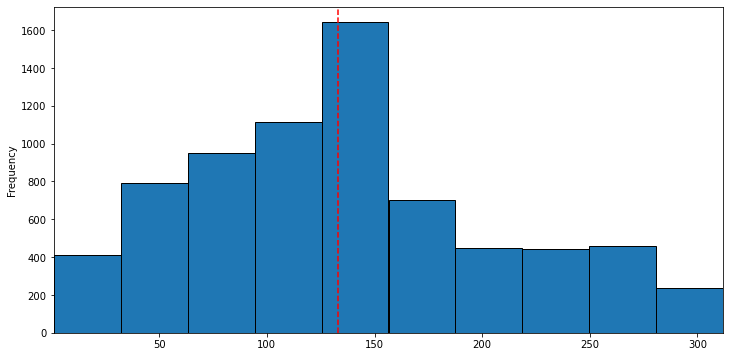

In [10]:
df['tweet_len'] = df['tweet'].map(lambda x: len(x))
print(df.tweet_len.describe().round())
df.tweet_len.plot(kind='hist',figsize=(12,6),edgecolor="k");
plt.axvline(df['tweet_len'].median(), ls = '--',color='r');
plt.margins(x=0);

#### Likes, replies and retweets count statistics
* The distribution's midian value is represented by vertical dashed lines.

In [11]:
def plot_counts_statistics(x):
    # To improve visualization and reflection of reality, outlairs were removed using np.clip.
    up_limit = df[x].mean() + df[x].std() * 4
    fig, ax = plt.subplots(figsize=(10,6))
    plt.hist(np.clip(df[x], 0, up_limit), bins=20,edgecolor="k")
    plt.axvline(df[x].median(),ls = '--', color='r');
    textstr = r'median=%.f' % (df[x].median().round())
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    plt.text(0.75, 0.95, textstr, fontsize=14,transform=ax.transAxes,verticalalignment='top', bbox=props)
    plt.title(f'{x.capitalize()} distribution', size=15)
    plt.margins(x=0);    

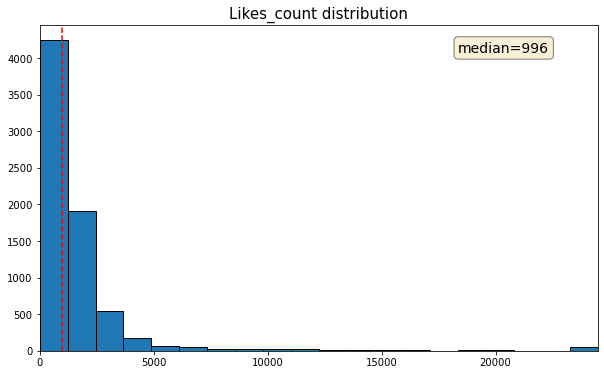

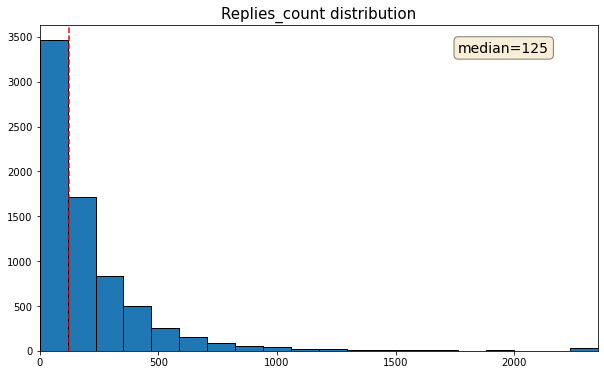

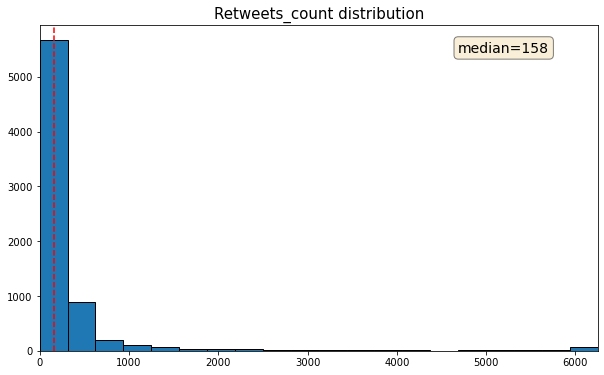

In [12]:
count_statitics= ['likes_count', 'replies_count', 'retweets_count']
for i in count_statitics:
    plot_counts_statistics(i)

#### kernel density estimate (KDE) plots to visualize the distribution of likes count for tweets with and without photos/videos/urls/mentions
* The distribution's midian value is represented by vertical lines.

In [13]:
def plot_targeted_feature(x, y):
    """
    Return KDE plots of two count ditrebutions. with and without x.
    """
    
    up_limit = df[y].mean() + df[y].std() * 2
    fig, ax = plt.subplots(figsize=(12,6))
    if x =='video':
        x1 = df[df[x] ==0][y]
        x2 = df[df[x] ==1][y]
    else:
        x1 = df[df[x] =="[]"][y]
        x2 = df[df[x] !="[]"][y]
    sns.set(font_scale = 1.1)
    sns.kdeplot(np.clip(x1, 0, up_limit), color="#e74c3c", shade=True, label =f'without {x}', alpha=0.6)
    sns.kdeplot(np.clip(x2, 0, up_limit), color="#34495e", shade=True, label=f'with {x}', alpha=0.6)
    plt.axvline(x1.median(), color='#e74c3c');
    plt.axvline(x2.median(), color='#34495e');
    plt.title(f'Tweets with {x.capitalize()} - likes count distribution', size=15, fontweight='bold')
    plt.margins(x=0); plt.legend();

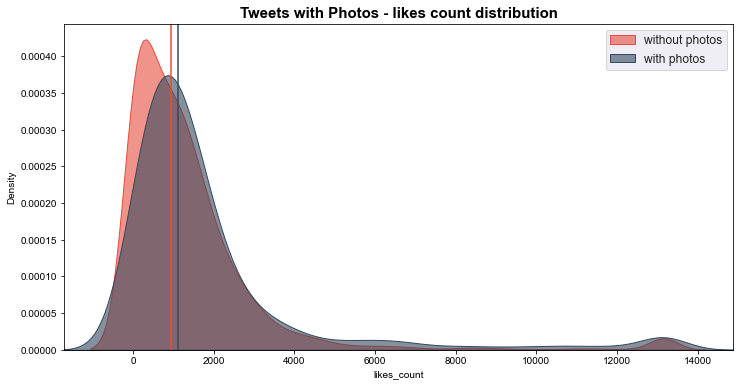

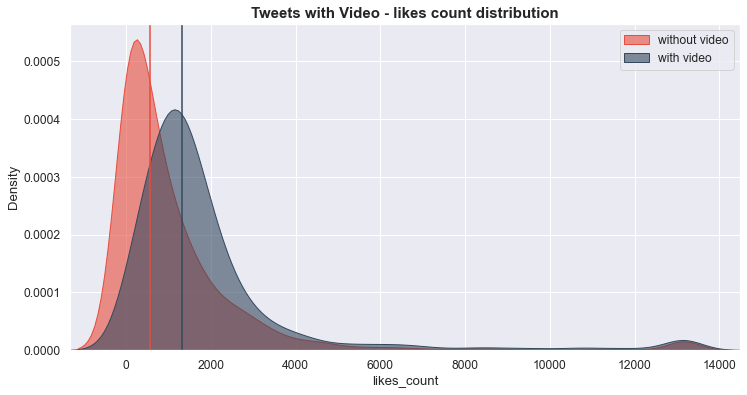

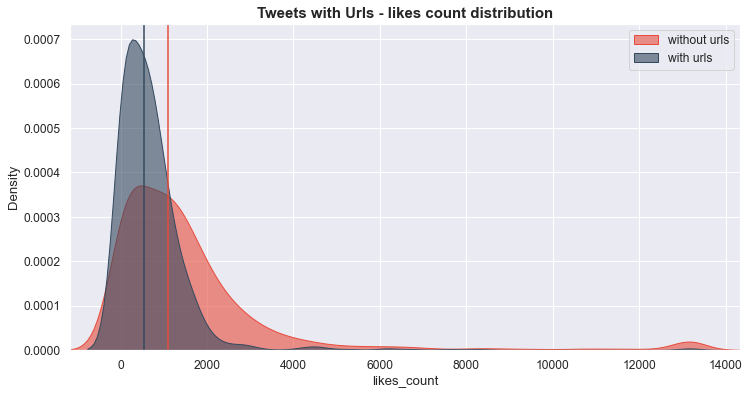

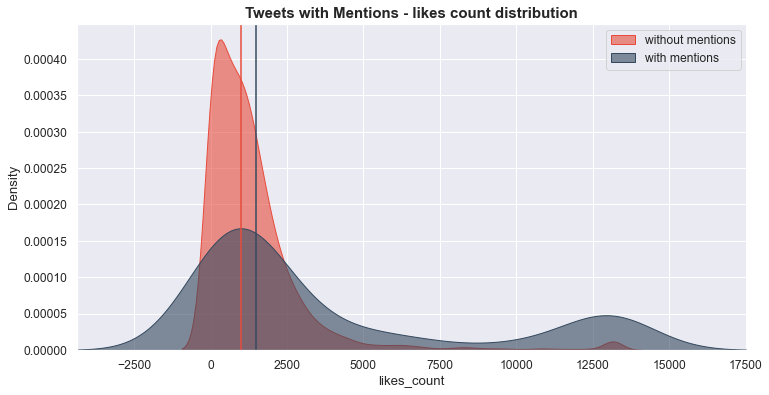

In [14]:
count_statitics2= ['photos', 'video', 'urls', 'mentions']
for i in count_statitics2:
    plot_targeted_feature(i,'likes_count')

<bold><font color='#34495e'>**When a video or mentions is added to a tweet, the number of likes increases,  
when an image is added, the number of likes stays the same, and when a URL included, the number of likes falls below the norm.** </font></bold>

### Correlation between retweets, replies and likes 

In [15]:
df[['replies_count','retweets_count','likes_count']].corr().round(2)

,replies_count,retweets_count,likes_count
replies_count,1.00,0.75,0.73
retweets_count,0.75,1.00,0.91
likes_count,0.73,0.91,1.00


### Tweets by time of the day

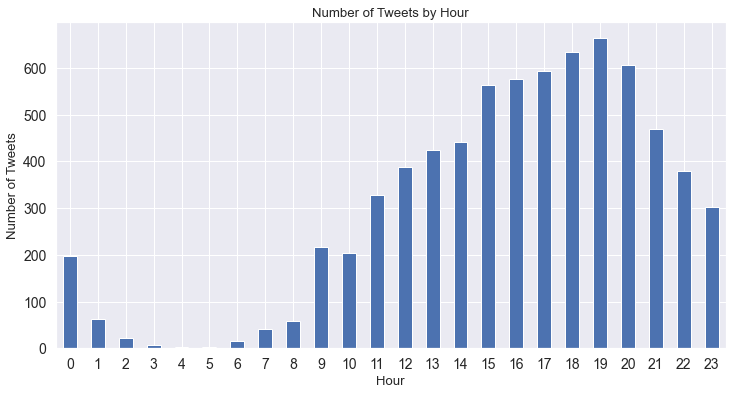

In [16]:
title = 'Number of Tweets by Hour'
df.tweet.groupby(df.time.dt.hour).count().plot(figsize=(12,6), fontsize=14, kind='bar', rot=0, title=title)
plt.xlabel('Hour')
plt.ylabel('Number of Tweets');

### Tweets by day of the week

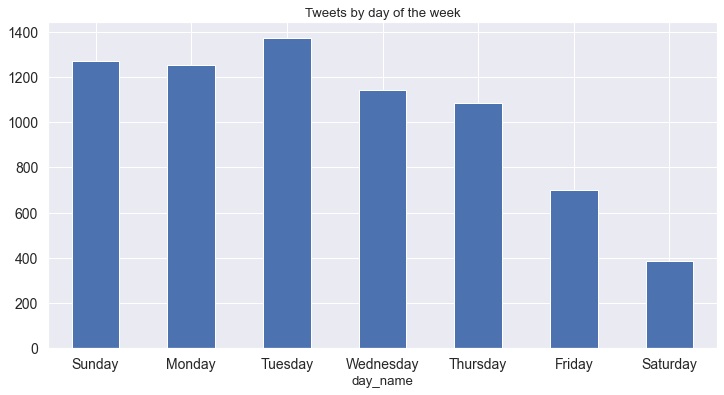

In [17]:
df['day_name'] = df["date"].dt.day_name()
cats= ['Sunday','Monday','Tuesday','Wednesday','Thursday','Friday','Saturday']
df_weekday = df.tweet.groupby(df['day_name']).count().reindex(cats)
title = 'Tweets by day of the week'
df_weekday.plot(figsize=(12,6), fontsize=14, kind='bar', rot=0, title=title);

####  <font color='#34495e'> As we can see, the largest number of tweets is in the evening, as well as on the weekends the number of tweets is the lowest because the prime minister does not tweet from the beginning to the end of Shabbat in order to respect religious feelings. </font>

### Top Mentions


4.91% of Benjamin Netanyahu tweets, contains mention of another username.


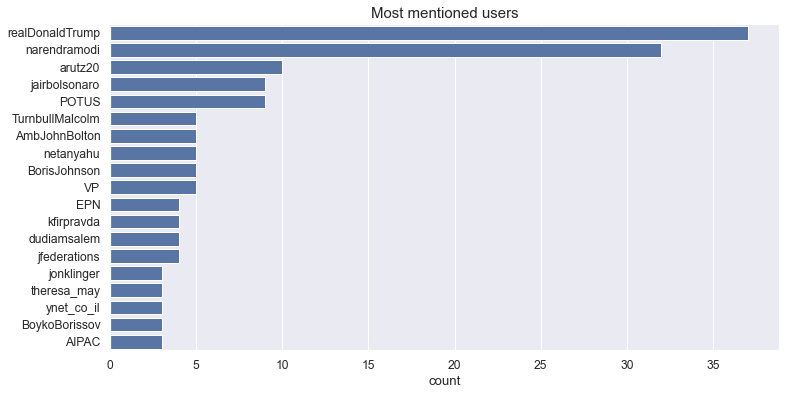

In [18]:
df['mention_user'] = df.tweet.str.findall(r'(?<![@\w])@(\w{1,25})').apply(','.join)
mentions_count = (df.mention_user.value_counts()[1:20]
                  .to_frame().reset_index()
                  .rename(columns={"index": "mention_user", "mention_user": "count"}))

print(f'\n{round(np.where(df["mentions"] !="[]",1,0).sum()/len(df)*100,2)}% of Benjamin Netanyahu tweets,'\
      f' contains mention of another username.')
plt.figure(figsize=(12,6))
sns.barplot(x=mentions_count['count'],y=mentions_count['mention_user'], color='b');
plt.title("Most mentioned users", size=15);plt.ylabel(''); 

### <u>Most liked tweets</u>

In [19]:
pd.set_option('display.max_colwidth', None)
likesorder=df[['likes_count','tweet']].sort_values(by=['likes_count'],ascending=False)
likesorder.head(5)

,likes_count,tweet
date,,
2019-05-23,164267,"मेरे दोस्त @narendramodi आपके प्रभावशाली चुनावी जीत पर हार्दिक बधाई! ये चुनावी नतीजे एक बार फिर दुनिया के सबसे बड़े लोकतंत्र में आपके नेतृत्व को साबित करते हैं। हम साथ मिलकर भारत और इज़राइल के बीच घनिष्ट मित्रता को मजबूत करना जारी रखेंगे । बहुत बढ़िया, मेरे दोस्त 🇮🇱🤝🇮🇳"
2020-08-14,158666,Wishing my very good friend @PMOIndia @narendramodi and all the people of #IncredibleIndia a joyful #IndiaIndependenceDay . You have so much to be proud of. स्वतंत्रता दिवस की हार्दिक शुभकामनाएं 🇮🇱🤝🇮🇳 https://t.co/OaW7tHgKrH
2019-08-15,156992,יום העצמאות שמח הודו! 🇮🇱🇮🇳 Happy Independence Day India! सभी भारतवासियों को इजरायल की ओर से स्वतंत्रता दिवस की हार्दिक शुभकामनायें। @NarendraModi https://t.co/7afares7we
2019-05-23,116539,"Congratulations, my friend @Narendramodi, on your impressive election victory! The election results further reaffirm your leadership of the world's largest democracy. Together we will continue to strengthen the great friendship between India &amp; Israel. Well done, my friend! 🇮🇱🤝🇮🇳"
2019-06-12,92766,"Thank you @NarendraModi, thank you India, for your support and for standing with Israel at the UN. 🇮🇱🇮🇳"


#### Visualize the most liked tweet

In [20]:
def show_tweet(link):
    """
    Return HTML display of a tweet.
    """
    url = f'https://publish.twitter.com/oembed?url={link}'
    response = requests.get(url)
    html = response.json()['html']
    display(HTML(html))
    
most_liked_tweet = df[df.likes_count == max(df.likes_count)]['link'].values[0]
show_tweet(most_liked_tweet)

**The most famous tweets were in Hindi in honor of India's Prime Minister,  
and the tweet with the most likes was in celebration of Narendra Modi's re-election in 2019.**

## <bold><u>Hebrew tweets</u></bold>

#### We'll now focus on analyzing the <u>Hebrew-language tweets</u>.

In [21]:
df = df[df.language =='iw']

### Average number of tweets/retweets/likes (Hebrew) vs. election days, time series review

In [22]:
# calculating election dates and the date, 90 days before the elections
election_dates = ['2015-03-17', '2019-04-09', '2019-09-17', '2020-03-02','2021-03-23']
three_month_bfore_election = []
for i in election_dates:
    three_month_bfore_election.append(str(dt.datetime.fromisoformat(i).date() - dt.timedelta(days=90)))

time_range_b4_elections = list(zip(three_month_bfore_election,election_dates))   
time_range_b4_elections

[('2014-12-17', '2015-03-17'),
 ('2019-01-09', '2019-04-09'),
 ('2019-06-19', '2019-09-17'),
 ('2019-12-03', '2020-03-02'),
 ('2020-12-23', '2021-03-23')]

The average number of tweets per month in the three months preceding the election of 2015-03-17:  81
The average number of tweets per month in the three months preceding the election of 2019-04-09:  121
The average number of tweets per month in the three months preceding the election of 2019-09-17:  130
The average number of tweets per month in the three months preceding the election of 2020-03-02:  137
The average number of tweets per month in the three months preceding the election of 2021-03-23:  178

When there is no election on the horizon (2015-04 -> 2018-12), the average number of tweets per month is: 32


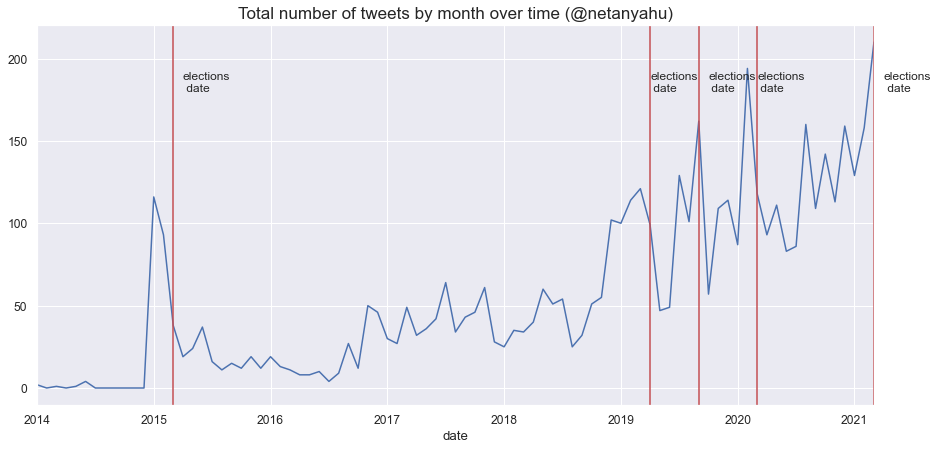

In [23]:
# calculating and plotting tweets by time series vs election dates, and 3 preceding months agg average number of tweets 

df['2014':].resample('M')['tweet'].count().plot(figsize=(15,7),y="");
plt.title("Total number of tweets by month over time (@netanyahu)",size=17);
for d in election_dates:
    plt.axvline(dt.datetime.fromisoformat(d), color='r')
    plt.text(dt.datetime.fromisoformat(d)+dt.timedelta(20),180,f'elections\n date',size=12)
for i in time_range_b4_elections:
    print(f"The average number of tweets per month in the three months preceding the election of {i[1]}: "\
          ,round(df[i[0]:i[1]].tweet.count()/3))
print()
print('When there is no election on the horizon (2015-04 -> 2018-12), the average number of tweets per month is:',
      round(df['2015-04':'2018-12-31'].groupby(pd.Grouper(freq='M'))['tweet'].count().mean()))

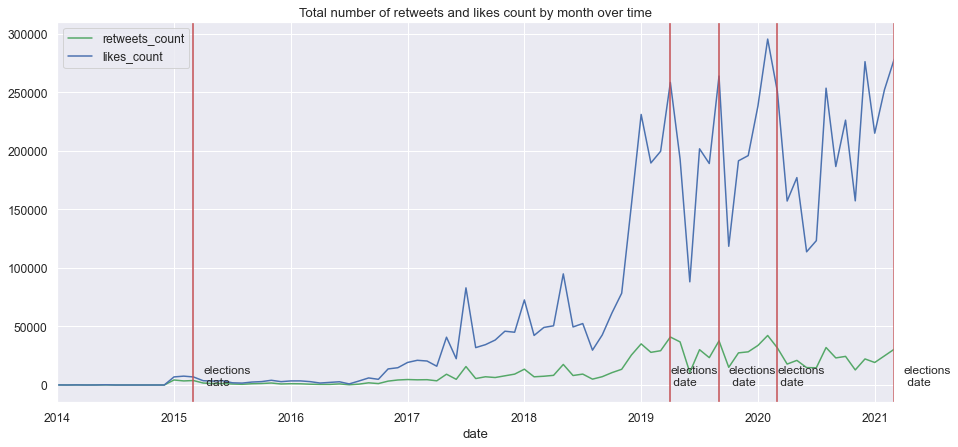

In [24]:
df['2014':].resample('M')[['retweets_count','likes_count']].sum().plot(figsize=(15,7), color=['g','b']);
plt.title("Total number of retweets and likes count by month over time");
for d in election_dates:
    plt.axvline(dt.datetime.fromisoformat(d), color='r')
    plt.text(dt.datetime.fromisoformat(d)+dt.timedelta(20),180,f'elections\n date',size=12)

#### Comparing the <u>top dates</u> with the most daily tweets to <u>election dates</u>.

In [25]:
# Top dates with the highest number of tweets
df.date.value_counts().head(10).to_frame('tweets_count')

,tweets_count
2019-09-17,26
2015-01-05,26
2021-03-22,25
2021-03-23,23
2015-01-11,21
2019-04-09,19
2019-09-16,17
2020-03-02,17
2008-12-08,17
2021-03-07,15


In [26]:
# Check if the election dates are also in the list of dates with the highest number of tweets.
for i in df.date.value_counts().head(10).index.strftime('%Y-%m-%d').tolist():
    if i in election_dates:
        print(i)

2019-09-17
2021-03-23
2019-04-09
2020-03-02


#### ** As can be shown, <SPAN STYLE="font-size:4mm;background: #D3D5DF;">four</span> out of the <SPAN STYLE="font-size:4mm;background: #D3D5DF;">five</span> election days are also among the <u>top tweeting dates</u>.

#### * I wrote a function that uses <u>GoogleNews</u> to investigate what happened in the news in order to explain the other dates (not election days) that in the top tweeting days.


In [27]:
def news_headline(date):
    """
    Return 5 news headlines (Israel/Hebrew) for a given date. 
    """
    gn = GoogleNews(country="Israel", lang="he")
    search = gn.search("נתניהו",from_=date, to_=str(dt.datetime.fromisoformat(date) + pd.Timedelta(days=1)))
    newsitem = search['entries']
    for i in newsitem[:5]:
        print(i.title)
        
for i in df.date.value_counts().head(10).index.strftime('%Y-%m-%d').tolist():
    if i not in election_dates:
        print(f'News for {i}: \n-------------------')
        print(news_headline(i))

News for 2015-01-05: 
-------------------
נתניהו משיק קמפיין הליכוד: מציע חוק משילות חדש ותוקף את השמאל - וואלה! - וואלה!
דיור, יוקר המחיה, גיוס לכולם ושיטת הממשל: הבטחות נתניהו שלא מומשו - ynet ידיעות אחרונות
סקר: נתניהו עדיין מוביל, הרצוג ולבני נשארים צמודים - וואלה! בחירות 2021 - וואלה!
חוק המשילות של נתניהו: ראש המפלגה הגדולה - אוטומטית ראש ממשלה - ynet ידיעות אחרונות
זה ראש הממשלה נתניהו או המלך הורדוס? - ynet ידיעות אחרונות
None
News for 2021-03-22: 
-------------------
עשר הסכנות בשלטון של נתניהו עם החרדים והכהניסטים - כלכליסט
התרחישים: המשך שלטון נתניהו, ניצחון לגוש השינוי ובחירות חמישיות - מעריב
הריאיון של נתניהו עם רינה מצליח: שיעור בגזלייטינג - הארץ
נתניהו חיקה את אייל שני - וזה המסר החריף שקיבל ממנו בתגובה - מעריב
השותפים של נתניהו: ימין של קודם אנחנו ואחר כך המדינה - כלכליסט
None
News for 2015-01-11: 
-------------------
"בצרפת אמרו: עדיף שנתניהו לא יגיע" - ynet ידיעות אחרונות
נתניהו בפאריס: "כל יהודי ויהודייה יתקבלו בישראל בזרועות פתוחות ובלב חם וחפץ" - ישראל היום
בחירות 

### Tweet text preprocessing

In [28]:
my_punctuation = string.punctuation.replace(",", "").replace(".","").replace("?","").replace("!","")
def remove_pe(text, p =string.punctuation):
    "remove punctuation and emojis"
    text_without = "".join([c for c in text if c not in p])
    text_without_pe =  emoji.get_emoji_regexp().sub(r'', text_without)
    return text_without_pe

def removeWeirdChars(text):
    weridPatterns = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               u"\U0001f926-\U0001f937"
                               u'\U00010000-\U0010ffff'
                               u"\u200d"
                               u"\u2640-\u2642"
                               u"\u2600-\u2B55"
                               u"\u23cf"
                               u"\u23e9"
                               u"\u231a"
                               u"\u3030"
                               u"\ufe0f"
                               u"\u2069"
                               u"\u2066"
                               u"\u200c"
                               u"\u2068"
                               u"\u2067"
                               "]+", flags=re.UNICODE)
    return weridPatterns.sub(r'', text)

In [29]:
# clean the text from punctuation, emojis, numbers, urls
df['clean_tweet'] = df['tweet'].apply(lambda x: remove_pe(x)).apply(lambda x: re.sub(r'[A-Za-z]|http\S+|[0-9]+', '',x))\
                     .apply(lambda x: removeWeirdChars(x))

In [30]:
# example of clean tweets 
df[["clean_tweet"]].tail(5)

,clean_tweet
date,
2021-03-24,הערב הבאנו את הליכוד להיות המפלגה הגדולה בישראל בפער גדול מאוד אנחנו בקידומת והמפלגה הגדולה מאחורינו בקידומת זהו הפער הגדול ביותר בין שתי מפלגות מובילות בישראל בעשרות השנים האחרונות
2021-03-24,אפשר וצריך להקים ממשלה יציבה בישראל ממשלה שהכלכלה שלנו מחייבת אותנו להקים אני מושיט יד לכל חברות וחברי הכנסת שמאמינים בעקרונות הללו אני מצפה מכולם לנהוג בדרך דומה כלפינו
2021-03-24,השעה מחייבת זאת והמדינה זקוקה לממשלה יציבה אסור לנו בשום אופן לגרור את ישראל לבחירות חמישיות צריך להקים ממשלה יציבה עכשיו כל אפשרות אחרת תביא אותנו מהר או מהר יותר לבחירות חמישיות ואסור לנו ללכת לשם
2021-03-24,שוחחתי הערב עם כל חברי הימין ואמרתי להם בואו נעשה את המעשה האחראי ונקים ממשלה יציבה ממשלה שתדאג לכל אזרחי ישראל
2021-03-24,בימים הקרובים לא אחסוך שום מאמץ בדיבור עם כל חברות וחברי הכנסת כדי להביא לישראל ממשלה יציבה זה מה שאזרחי ישראל מצפים איתנו לעשות למנוע בחירות חמישיות ולהקים ממשלה טובה ויציבה לישראל


In [31]:
# importing text file with Hebrew stop words
with open('he_stop_words.txt', "r") as f:
    he_s_words = f.readline().split(',')
he_s_words = [i.strip() for i in he_s_words]

In [32]:
def process_text(text):
    """
    Return tokenized(spliting each tweet to words) and removing Hebrew stop words.
    """
    tokens = word_tokenize(text)
    remove_stopwords = [token for token in tokens if token not in he_s_words]
    return remove_stopwords

In [33]:
df['tokenized_text'] = df['clean_tweet'].apply(process_text)
df[['tokenized_text']].head()

,tokenized_text
date,
2008-10-30,"[בערב, כנסים, ברמלה, ובגבעתים]"
2008-11-02,"[נכנס, עכשיו, למסיבת, עיתונאים, מירי, רגב, מצטרפת, חדשה, לליכוד]"
2008-11-03,"[בישיבת, סיעה, בכנסת]"
2008-11-05,"[העלינו, עמוד, תומכים, בפייסבוק]"
2008-11-06,"[עובדים, במרץ, אתר, חדש]"


In [34]:
print(f"Out of {df.clean_tweet.str.split(' ').str.len().sum()} words in {len(df)} tweets"\
     f", {df.clean_tweet.str.split(' ').str.len().sum() - df.tokenized_text.str.len().sum()} stop words were removed.") 

Out of 118733 words in 5208 tweets, 32927 stop words were removed.


#### Most common phrases (trigrams)  2008 $\Rightarrow$  today

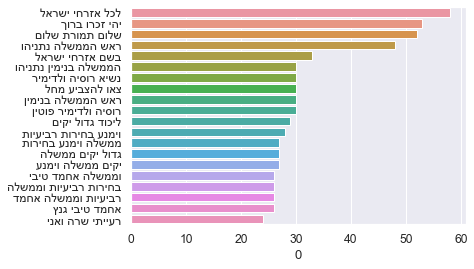

In [35]:
top=20
firstword=""
c=CountVectorizer(stop_words=he_s_words,ngram_range=(3,3))
X=c.fit_transform(df['clean_tweet'].tolist())
words=pd.DataFrame(X.sum(axis=0),columns=c.get_feature_names()).T.sort_values(0,ascending=False).reset_index()
res=words[words['index'].apply(lambda x: firstword in x)].head(top)
terms = [get_display(x) for x in res['index']]
sns.barplot(x=res[0], y=terms); 

#### What words did Benjamin Netanyahu use the most in his tweets <u>within the three months leading up to the five most recent elections</u>? 

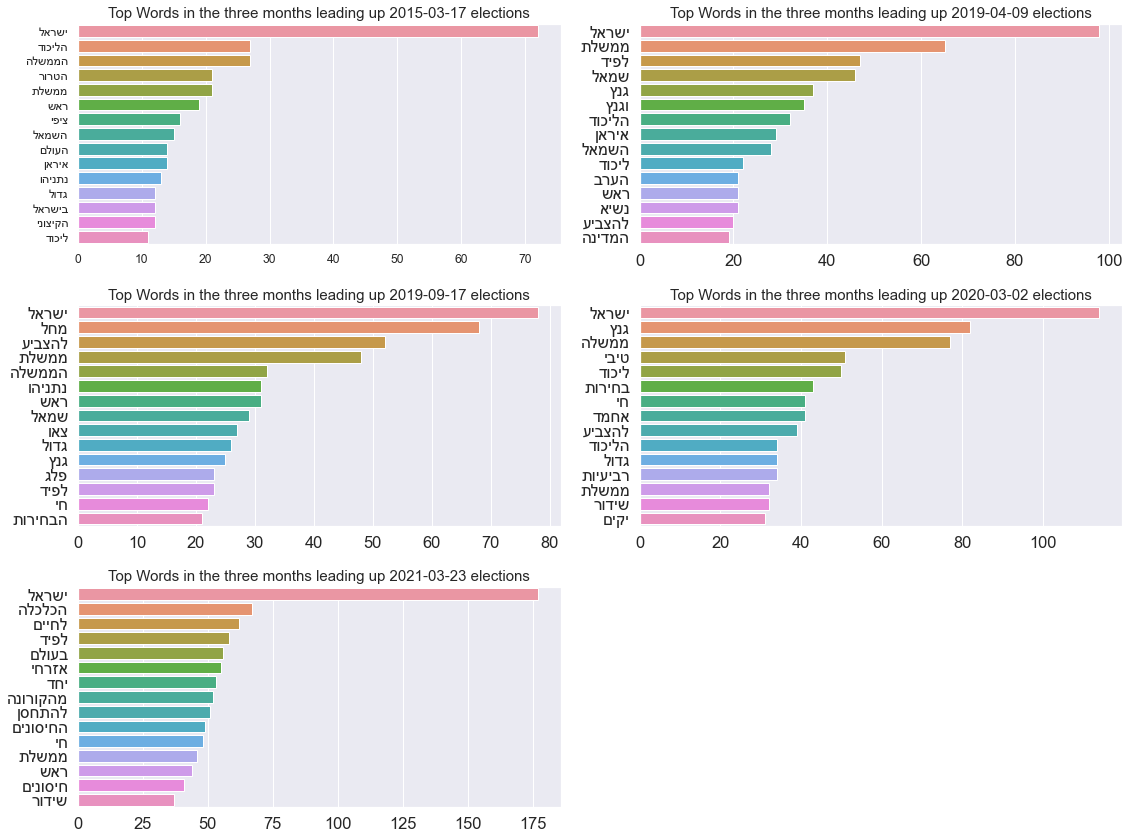

In [36]:
# iterate through each tweet, each token in each tweet, store in a list, plot performance
plt.rcParams['figure.figsize'] = [16, 12]
for index, i in enumerate(time_range_b4_elections):
    flat_words = [item for sublist in df.loc[i[0]:i[1],'tokenized_text'] for item in sublist]
    word_freq = FreqDist(flat_words).most_common(15)
    terms = [get_display(x) for x, y in word_freq]
    count= [y for x, y in word_freq]
    plt.subplot(3, 2, index+1);sns.set(font_scale = 1.5);plt.tight_layout();
    sns.barplot(x=count,y=terms); plt.title(f"Top Words in the three months leading up {i[1]} elections", size=15);

### Words Timeline Occurrences

I wanted to see how words emerge and change in Benjamin Netanyahu's tweets over time, so I created a function that tests when a word appears in tweets, counts the amount of occurrences, and normalizes them to the number of quarterly tweets in order to determine their relative significance.I narrowed the search to 2015 and later, both because it seems that the popularity of usage (as measured by the number of tweets) has grown since then, and because I wanted to review more specific words and events.

In [37]:
def words_over_time(*argv):
    """
    Return timeline bar plot of normalized words count to quarterly sum of tweets
    """
    temp_df = df['2015':][['tweet']].copy()
    for term in argv:
        temp_df[term] = np.where(temp_df.tweet.str.contains(term),1,0)
    temp_df_q = round((temp_df.resample('Q').sum()/temp_df.resample('Q').count()*100),1).fillna(0)
    temp_df_q.index = temp_df_q.index.strftime('%Y-%m')
    temp_df_q = temp_df_q.T[1:]
    temp_df_q.T.plot(kind='bar',width=0.8, figsize=(18,5));
    lgd = [get_display(x) for x in temp_df_q.index]
    plt.legend(lgd,loc='upper left',fontsize=15);ax = plt.axes();
    ax.set_title('Words timeline as a percentage of quarterly tweets', fontsize=15)
    ax.yaxis.set_major_formatter(mtick.PercentFormatter())    


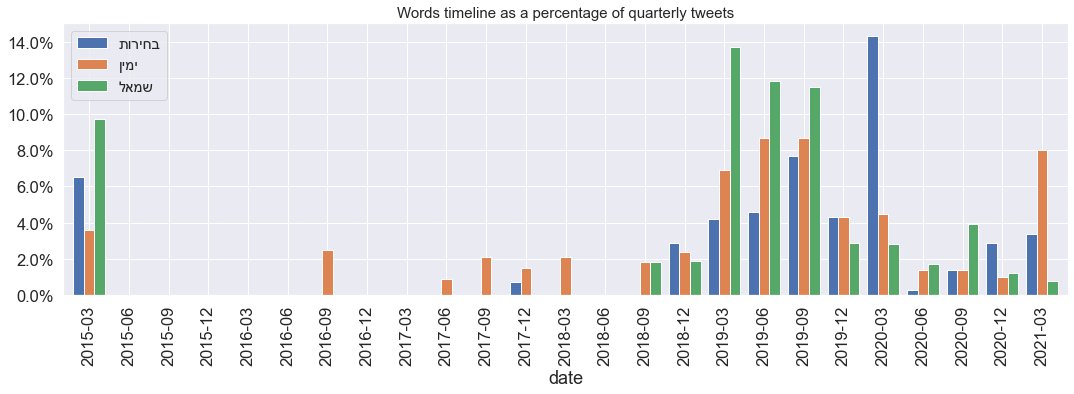

In [38]:
words_over_time('בחירות','שמאל','ימין')

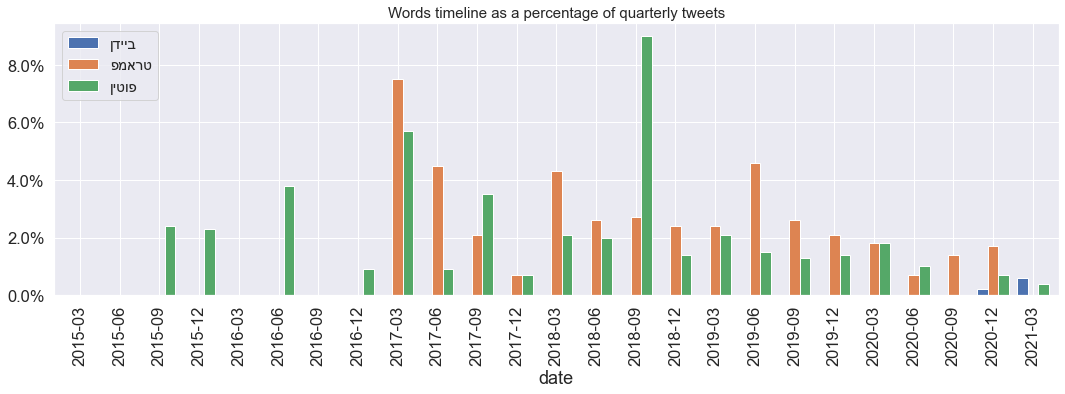

In [39]:
words_over_time('ביידן','טראמפ','פוטין')

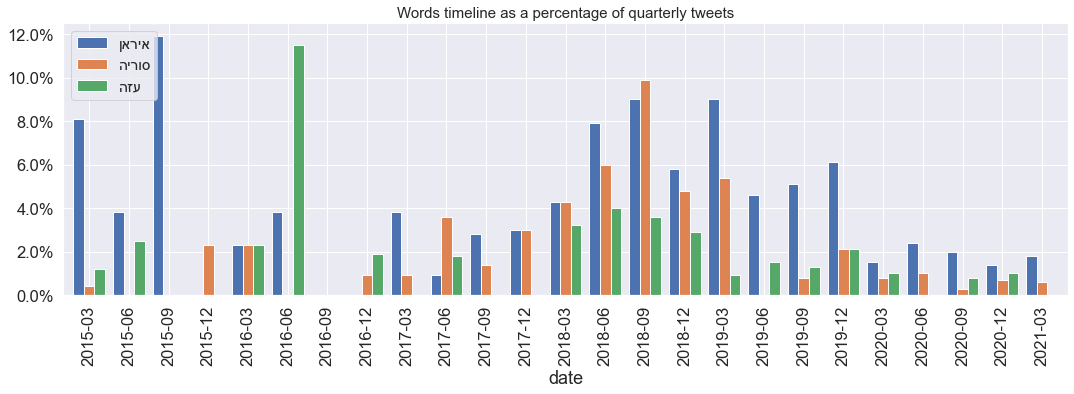

In [40]:
words_over_time('איראן','סוריה','עזה')

### <u>Word Cloud</u> 
#### (Text data visualization. Displays a list of words with varying sizes to reflect their significance).

In [41]:
# Making tweets into one big list and putting out the stop words (preparation for word cloud)
temp = " ".join(df['clean_tweet'].tolist())
temp = " ".join([i for i in temp.split() if i not in he_s_words]) 

wordcloud = WordCloud(width=800, height=500,
                      font_path = 'C:\Windows\Fonts\courbd.ttf',
                      background_color='white',max_words=30,
                      min_font_size= 10).generate(get_display(temp))

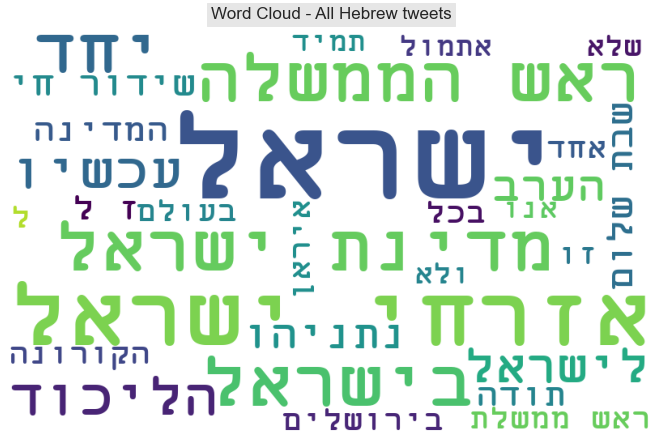

In [42]:
plt.figure(figsize=(9,9))
plt.imshow(wordcloud)
plt.axis('off')
plt.tight_layout(pad = 0);
plt.title("Word Cloud - All Hebrew tweets", backgroundcolor = '0.9', size=17, pad=15);

#### WordCloud by default includes <u>bigrams</u> (sequence of two adjacent words).
#### There seems to be a problem with applying Hebrew-stop words. As we see in the words presentation, the same term appears several times because the stopwords are prefix and suffix connected with the term itself. In this example 'and'/'in'/'the'/'as'/'like'..etc.. 

In [43]:
# An example of the difficulties in replacing stop words in Hebrew. 
tweets_words_example = list(set([word for tokens in df['clean_tweet'].str.split() for word in tokens]))[:10]
tweets_words_example

['פורטוגל',
 'מוחרם',
 'איתנים',
 'החסידי',
 'שהוריו',
 'מתמודדים',
 'תיקים',
 'תקוע',
 'מתחרות',
 'באבו']

In the example above, half of the words are preceded by prefix letters.  
In order to try and process the language better, I will try to translate part of the dataset.

### Taking the past six months (182 days) tweets and <u>translate</u> them from Hebrew $\Rightarrow$ English

In [44]:
# clean the text from punctuation (except commas & periods), emojis, numbers, urls
df['clean_tweet_for_translate'] = df['tweet'].apply(lambda x: remove_pe(x, my_punctuation))\
                                 .apply(lambda x: re.sub(r'[A-Za-z]|http\S+|[0-9]+', '',x))\
                                 .apply(lambda x: removeWeirdChars(x))

In [45]:
def translate(text):
    """
    Return English translated text.
    """
    translator = Translator()
    result = translator.translate(text,dest='en')
    return result.text

In [46]:
# generating a new data frame from the last six months tweets
# date_6m_ago = (df.tail(1).index.date - dt.timedelta(days=182))[0].strftime('%d/%m/%Y')
# df_with_trans = df[df.index >= date_6m_ago].copy()

In [47]:
# %%time
# # translte Hebrew tweets to English uing GoogleTranslate
# df_with_trans['he_trans'] = df_with_trans['clean_tweet_for_translate'].apply(lambda x: translate(x))

In [48]:
# df_with_trans.to_pickle("./bn_tweets_with_translation.pkl")

In [49]:
df_with_trans = pd.read_pickle("bn_tweets_with_translation.pkl")

#### Examples of Hebrew-to-English tweet translations

In [50]:
df_with_trans[['clean_tweet','he_trans']].rename(columns={'clean_tweet':'Hebrew','he_trans':'English'}).tail(5)

,Hebrew,English
date,,
2021-03-24,הערב הבאנו את הליכוד להיות המפלגה הגדולה בישראל בפער גדול מאוד אנחנו בקידומת והמפלגה הגדולה מאחורינו בקידומת זהו הפער הגדול ביותר בין שתי מפלגות מובילות בישראל בעשרות השנים האחרונות,The evening we brought the Likud to be the largest party in Israel in a very large gap.We are in the prefix and the largest party behind us in the prefix.This is the largest gap between two leading parties in Israel in the last decades
2021-03-24,אפשר וצריך להקים ממשלה יציבה בישראל ממשלה שהכלכלה שלנו מחייבת אותנו להקים אני מושיט יד לכל חברות וחברי הכנסת שמאמינים בעקרונות הללו אני מצפה מכולם לנהוג בדרך דומה כלפינו,It is possible to establish a stable government in Israel.The government whose economy requires us to establish.I reach for all membership and members of the Knesset who believe in these principles.I expect anyone to drive a similar way to us
2021-03-24,השעה מחייבת זאת והמדינה זקוקה לממשלה יציבה אסור לנו בשום אופן לגרור את ישראל לבחירות חמישיות צריך להקים ממשלה יציבה עכשיו כל אפשרות אחרת תביא אותנו מהר או מהר יותר לבחירות חמישיות ואסור לנו ללכת לשם,The time requires it and the state needs a stable government.We are not allowed in any way to drag Israel to fifth elections should establish a stable government now.Any other option will bring us quickly or faster for fifth elections and we must not go there
2021-03-24,שוחחתי הערב עם כל חברי הימין ואמרתי להם בואו נעשה את המעשה האחראי ונקים ממשלה יציבה ממשלה שתדאג לכל אזרחי ישראל,"I talked tonight with all the right members and told them let's do the act in charge of a stable government, a government to worry about all citizens of Israel"
2021-03-24,בימים הקרובים לא אחסוך שום מאמץ בדיבור עם כל חברות וחברי הכנסת כדי להביא לישראל ממשלה יציבה זה מה שאזרחי ישראל מצפים איתנו לעשות למנוע בחירות חמישיות ולהקים ממשלה טובה ויציבה לישראל,"In the coming days, I will not take any effort to speak with any companies and members of the Knesset in order to bring Israel a stable government.That's what Israel's citizens look forward to doing.Avoid fifth elections and establish a good government and steady to Israel."


In [51]:
# Making tweets into one big list and putting out the stop words
temp1 = " ".join(df_with_trans['he_trans'].tolist())
temp1 = " ".join([i for i in temp1.split() if i not in stopwords.words('english')]) 

In [52]:
wordcloud = WordCloud(width=800, height=500,
                      background_color='white',max_words=30,
                      min_font_size= 10).generate(temp1)

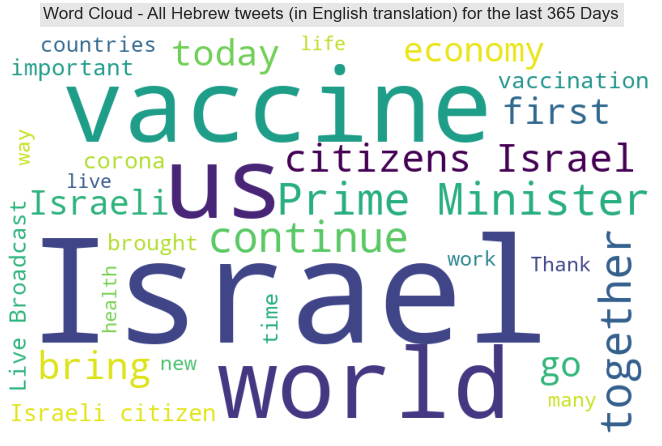

In [53]:
plt.figure(figsize=(9,9))
plt.imshow(wordcloud)
plt.axis('off')
plt.tight_layout(pad = 0);
plt.title("Word Cloud - All Hebrew tweets (in English translation) for the last 365 Days",\
          backgroundcolor = '0.9',size=17, pad=15);

### <u>Named-entity recognition (NER)</u>
#### Lets see how Spacy handle information extraction that seeks to locate and classify named entities mentioned in our tweets text into pre-defined categories such as person names, organizations, locations, time expressions etc.

In [54]:
nlp = en_core_web_sm.load()
ent = nlp(temp1)
df_ent = pd.DataFrame([(X.text, X.label_) for X in ent.ents], columns = ['Word','Entity'])

#### Organizations

In [55]:
df_ent.where(df_ent['Entity'] == 'ORG').value_counts().head()

Word     Entity
Likud    ORG       58
State    ORG       34
GPO      ORG       20
Knesset  ORG       10
NIS      ORG        6
dtype: int64

#### Persons

In [56]:
df_ent.where(df_ent['Entity'] == 'PERSON').value_counts().head()

Word              Entity
Netanyahu         PERSON    27
Shabbat Shalom    PERSON    15
Sarah             PERSON    15
Amos Ben Gershom  PERSON    11
Trump             PERSON     7
dtype: int64

#### Geo-Political Entity

In [57]:
df_ent.where(df_ent['Entity'] == 'GPE').value_counts().head()

Word       Entity
Israel     GPE       347
Iran       GPE        17
Corona     GPE        16
Jerusalem  GPE        15
Korona     GPE        14
dtype: int64

#### Nationalities or religious or political groups

In [58]:
df_ent.where(df_ent['Entity'] == 'NORP').value_counts().head()

Word      Entity
Israeli   NORP      101
Arab      NORP       33
Jewish    NORP       14
Israelis  NORP       13
European  NORP       10
dtype: int64

#### Date

In [59]:
df_ent.where(df_ent['Entity'] == 'DATE').value_counts().head()

Word       Entity
today      DATE      51
Today      DATE      11
yesterday  DATE      10
Yesterday  DATE       7
months     DATE       6
dtype: int64

#### Cardinal (numbers that do not fit into another category)

In [60]:
df_ent.where(df_ent['Entity'] == 'CARDINAL').value_counts().head()

Word      Entity  
millions  CARDINAL    21
two       CARDINAL    19
one       CARDINAL    18
million   CARDINAL     5
billion   CARDINAL     4
dtype: int64

#### Time

In [61]:
df_ent.where(df_ent['Entity'] == 'TIME').value_counts().head()

Word          Entity
evening       TIME      9
morning       TIME      6
minutes       TIME      3
tonight       TIME      3
This evening  TIME      2
dtype: int64

#### Events

In [62]:
df_ent.where(df_ent['Entity'] == 'EVENT').value_counts().head()

Word                          Entity
Holocaust                     EVENT     2
International Day             EVENT     1
Operation "Returns Life       EVENT     1
Operation "Returns Life" All  EVENT     1
The Yom Kippur War            EVENT     1
dtype: int64

<b>NER generating raw markup example:</b>

In [63]:
displacy.render(nlp(df_with_trans['he_trans'].tail(1).values[0]), jupyter=True, style='ent')

### NER conclusion: Not perfect, to say the least. There are a number of recognition mistakes, most of them within the Organization entities.

## <u>Sentiment Analysis</u>  
with TextBlob

In [64]:
df_with_trans['polarity'] = df_with_trans['he_trans'].apply(lambda x:TextBlob(x).sentiment[0])
df_with_trans['subjectivity'] = df_with_trans['he_trans'].apply(lambda x:TextBlob(x).sentiment[1])
df_with_trans['sentiment'] = df_with_trans['polarity'].apply(lambda x: 'pos' if x>0 else ('neg' if x<0 else 'neu'))

In [65]:
sp_corr= df_with_trans[['polarity','subjectivity']].corr().iloc[1,0].round(2)
print(f'There is a positive correlation of {sp_corr} between subjectivity and polarity in the tweets.')

There is a positive correlation of 0.57 between subjectivity and polarity in the tweets.


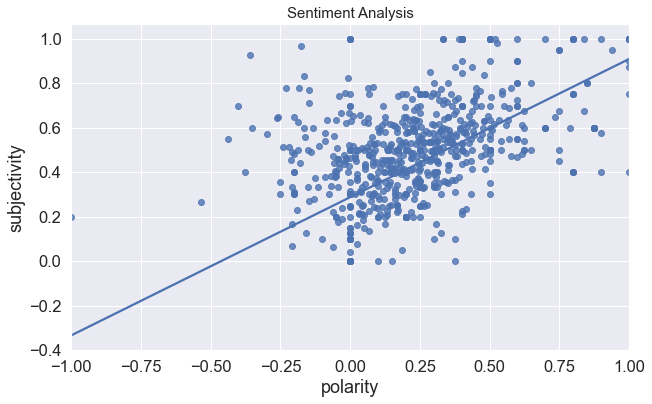

In [66]:
plt.figure(figsize=(10,6))
sns.regplot(x='polarity',y='subjectivity', data=df_with_trans,ci=None)\
.set_title('Sentiment Analysis',size=15);

Positive & Negative (%)
pos    66.17
neu    23.95
neg     9.88
Name: sentiment, dtype: float64


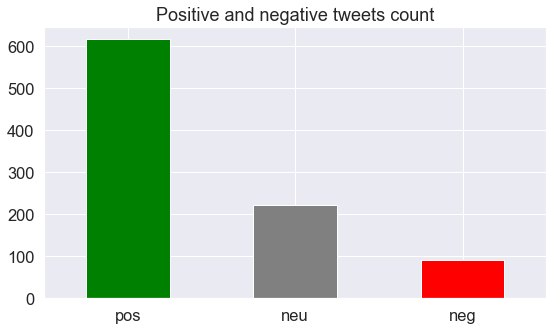

In [67]:
df_with_trans['sentiment'].value_counts().plot(kind='bar', color=['green','grey','red'],
                           figsize=(9,5),title="Positive and negative tweets count"); plt.xticks(rotation=0);

print('Positive & Negative (%)')
print(round(df_with_trans['sentiment'].value_counts(normalize=True)*100,2))

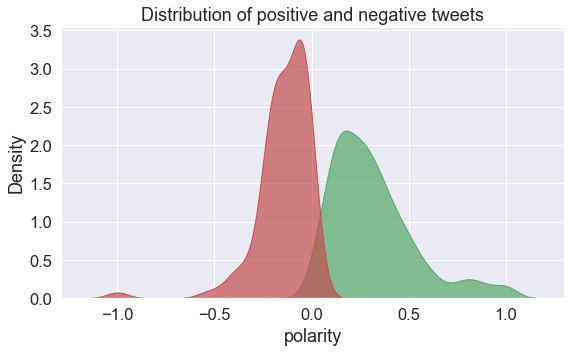

In [68]:
plt.figure(figsize=(9,5))
sns.kdeplot(df_with_trans[df_with_trans['polarity']>0]['polarity'], color="g", shade=True, alpha=0.7)
sns.kdeplot(df_with_trans[df_with_trans['polarity']<0]['polarity'], color="r", shade=True, alpha=0.7);
plt.title("Distribution of positive and negative tweets");

In [69]:
df_with_trans.loc[df_with_trans['polarity']>0].nlargest(3,'polarity')[['clean_tweet','polarity']]

,clean_tweet,polarity
date,,
2020-10-09,שבת שלום וחג שמח לכל אזרחי ישראל,1.0
2020-11-16,חג סיגד שמח,1.0
2020-12-11,שבת שלום וחג חנוכה שמח לכולכם,1.0


In [70]:
df_with_trans.loc[df_with_trans['polarity']<0].nsmallest(1,'polarity')[['clean_tweet_for_translate', 'he_trans','polarity']]

,clean_tweet_for_translate,he_trans,polarity
date,,,
2021-03-11,תודה לכם על איחולי ההחלמה והבריאות לרעייתי שרה. ריגשתם אותנו. שרה ואני מודים לכולכם. אוהבים אתכם! .,Thank you for the grief of recovery and health to my wife Sarah.You moved us.Sarah and I thank all of you.love you!.,-1.0


#### As we can see, there are certain complexities in the definition of sentiment in terms of sarcasm/cynicism such as the use of opposing negative/positive expressions, and poor translation as within the example above..

#### >   <font color='red'>*The results of sentiment ratings must be treated with caution. Sentiment in TextBlob is based on signaling sentiment for each particular word. When translating from Hebrew to English, we run into a challenge, as I said, with sarcasm (which is also similar to the use of sarcasm in other languages) and inaccurate translation of some terms, since there are words in Hebrew that have several meanings.***</font>

## <u>Sentiment Analysis with HeBERT</u>   
Pre-trained BERT for Polarity Analysis

As we have shown, sentiment analysis suffers from a variety of defects. As a result, I wanted to take a different approach, using tweets in <b>Hebrew</b> (rather than translated ones) and a neural network model that had already been trained on Hebrew corpora.  
We well use it as a sentiment classification model (polarity ONLY).

HeBERT is a Hebrew pretrained language model. It is based on Google's BERT architecture and it is BERT-Base config **[Link](https://github.com/avichaychriqui/HeBERT)

In [71]:
from transformers import AutoTokenizer, AutoModel, pipeline
tokenizer = AutoTokenizer.from_pretrained("avichr/heBERT_sentiment_analysis")
model = AutoModel.from_pretrained("avichr/heBERT_sentiment_analysis")

In [72]:
sentiment_analysis = pipeline(
    "sentiment-analysis",
    model="avichr/heBERT_sentiment_analysis",
    tokenizer="avichr/heBERT_sentiment_analysis",
    return_all_scores = True)


In [73]:
df_heBert = df_with_trans.copy()
df_heBert['s_heBert'] = df_heBert['clean_tweet_for_translate'].apply(lambda x: sentiment_analysis(x))

In [74]:
df_heBert['natural'] = df_heBert['s_heBert'].apply(lambda x: float([d['score'] for d in x[0] if d['label'] == 'natural'][0]))
df_heBert['positive'] = df_heBert['s_heBert'].apply(lambda x: float([d['score'] for d in x[0] if d['label'] == 'positive'][0]))
df_heBert['negative'] = df_heBert['s_heBert'].apply(lambda x: float([d['score'] for d in x[0] if d['label'] == 'negative'][0]))

In [75]:
df_heBert['s_heBert_label'] = np.where(df_heBert['positive']>0.5, 'pos',
                              np.where(df_heBert['negative']>0.5, 'neg', 'neu'))

Positive & Negative (%)
pos    49.84
neg    42.21
neu     7.95
Name: s_heBert_label, dtype: float64


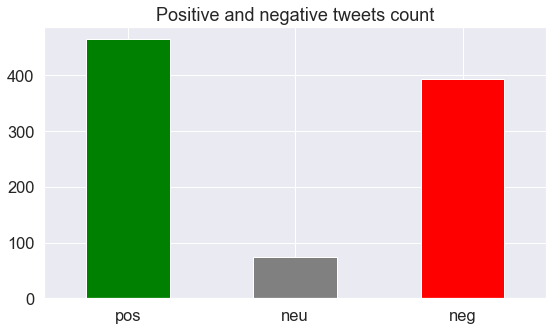

In [76]:
df_heBert['s_heBert_label'].value_counts()[['pos','neu','neg']].plot(kind='bar', color=['green','grey','red'],
                            figsize=(9,5),title="Positive and negative tweets count"); plt.xticks(rotation=0);

print('Positive & Negative (%)')
print(round(df_heBert['s_heBert_label'].value_counts(normalize=True)*100,2))

In [77]:
# examples of positive tweets
df_heBert.loc[df_heBert['positive']>0.5].nlargest(3,'positive')[['clean_tweet','positive']]

,clean_tweet,positive
date,,
2021-01-06,התרגשתי לפגוש היום את הילה שורץ במתחם החיסונים בירושלים הילה בת מתוקה אמיתית שמאובחנת עם תסמונת נדירה למרות כל הקשיים היא נלחמת על החיים מתוך שמחה ואהבה אדירה הייתה לי הזכות להכיר אותה היום הרבה בריאות הילה,0.999762
2021-03-12,תודה רבה אלברט בורלה מנכ״ל פייזר על האמון שנתת בי ובאזרחי ישראל תודה לכם אזרחי ישראל על ההקרבה בשנה האחרונה יחד הפכנו את ישראל להצלחה עולמית ותקווה לאנושות כולה כפי שהייתי אובססיבי לחיסונים עכשיו אני אובססיבי להזניק את הכלכלה שלנו למקום הראשון בעולם,0.999762
2021-02-25,הילדים המתוקים שפגשתי אתמול עם עמותת ״רחשי לב״ לימדו אותי על עוצמה וגבורה אוהב אתכם מאוד רפואה שלמה מכל אזרחי ישראל,0.999762


In [78]:
# examples of negative tweets
df_heBert.loc[df_heBert['negative']>0.5].nlargest(3,'negative')[['clean_tweet','negative']]

,clean_tweet,negative
date,,
2021-02-10,בן גביר לא יהיה בממשלה אבל כמה צביעות זה להתעלם מחברת מפלגת העבודה שמבזה את הצפירה ביום השואה ושבלעדיה לגדעון בנט ולפיד אין ממשלה רק אנחנו נקים ממשלת ימין על מלא,0.999901
2021-03-01,מאלה שנפטרו מהקורונה לא היו מחוסנים בשתי מנות לכן אני לא מוכן לסבול את שיבוש הנחיות הבריאות ואת הדהלגיטימציה לחיסונים שעושים פוליטיקאים ציניים אליהם התייחסתי היום יש לי אפס סבלנות לפייק ניוז בזמן שאני נלחם להצלת חיים לכו להתחסן והצילו את החיים שלכם,0.999901
2020-12-21,זה מצער אותי כי במקום לאפשר לממשלה לעבוד למען האזרחים ההתעקשות היא להמשיך ״ממשלה בתוך ממשלה״ בניסיון כושל לקושש קולות למפלגה שלא בדיוק מצליחה בסקרים אנחנו לא רוצים בחירות ולכן היינו מוכנים להצביע בכנסת נגד בחירות ולהמשיך יחד אבל אם בחירות יכפו עלינו אנחנו ננצח,0.999900


In [79]:
textBlob_sentiment = df_with_trans['sentiment'].value_counts(normalize=True)[['pos','neu','neg']]
heBert_sentiment = df_heBert['s_heBert_label'].value_counts(normalize=True)[['pos','neu','neg']]
textBlob_v_heBert = pd.concat([textBlob_sentiment, heBert_sentiment], keys= ['textBlob', 'heBert'], axis=1).T

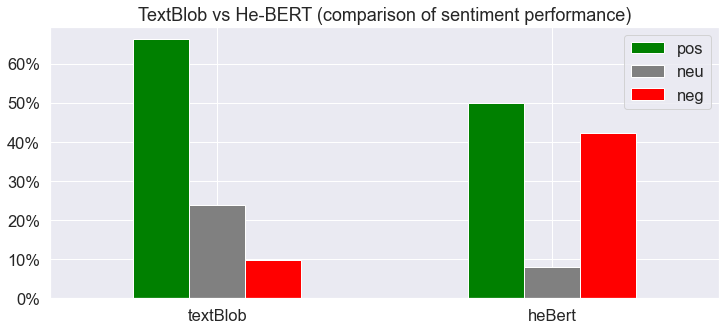

In [80]:
ax = textBlob_v_heBert.plot(kind='bar',color=['green','grey','red'],figsize=(12,5),
                       title="TextBlob vs He-BERT (comparison of sentiment performance)"); plt.xticks(rotation=0);
ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1))

**There is a considerable difference between the two models. Provided that Bert's model was trained on a Hebrew corpus, as well as his input in Hebrew rather than English translated from Hebrew (with all of the of the related issues I described earlier), and after inspecting some of the translations, it appears that the He-BERT model is more accurate and consistent.**

In [81]:
last_6m_sentiment = df_heBert.groupby('s_heBert_label').resample('W').size().unstack(0, fill_value=0)
last_6m_sentiment.index = last_6m_sentiment.index.strftime('%y-%m-%d')

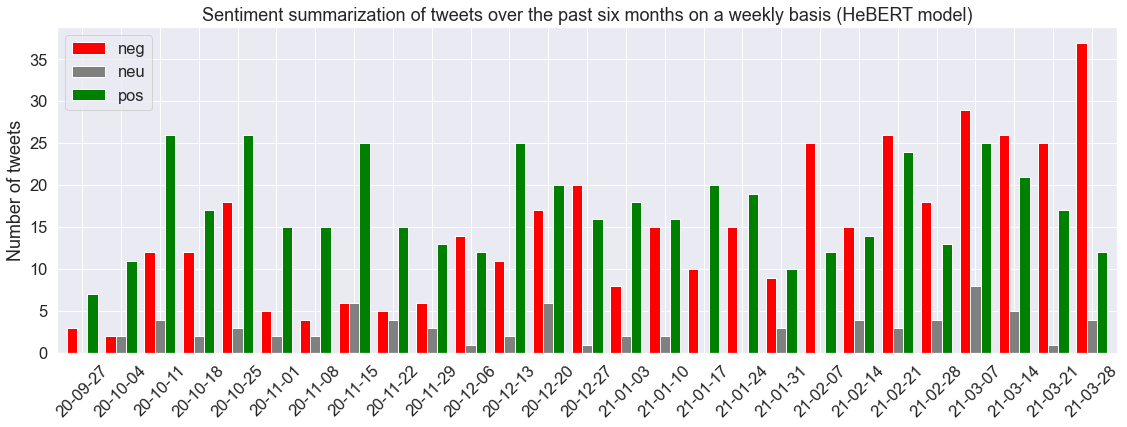

In [82]:
last_6m_sentiment.plot(kind='bar',width=0.8,color=['red','grey','green'] ,figsize=(19,6));
plt.title('Sentiment summarization of tweets over the past six months on a weekly basis (HeBERT model)');
plt.legend(loc="upper left");plt.xticks(rotation=45); plt.ylabel('Number of tweets');plt.xlabel("");